# A. Data Preprocessing

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import re
from wordcloud import WordCloud
from tensorflow.keras.callbacks import EarlyStopping

# PreProcessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec

# CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Input

# Bi-LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding,
    Bidirectional,
    LSTM,
    Dropout,
    Dense,
    Input,
)

# GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, GRU, Dense


# Confusion Matrix
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
)

## 1. Exploring the dataset

In [37]:
# Load the dataset
file = "training.300000.processed.noemoticon.csv"
sentiment_df = pd.read_csv(file, encoding="ISO-8859-1", low_memory=False)

In [38]:
sentiment_df.head(5)

,sentiment,id,date,query,username,text
0,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
1,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo..."
2,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...
3,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...
4,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem


In [39]:
df_selected = sentiment_df[["sentiment", "text"]].copy()

In [40]:
# Convert sentiment values from 0 (negative) and 4 (positive) to binary 0 and 1
df_selected["sentiment"] = df_selected["sentiment"].map({0: 0, 4: 1})

# Check for missing data in the 'sentiment' and 'text' columns
missing_data = df_selected[["sentiment", "text"]].isnull().sum()
print("Missing data before dropping rows:\n", missing_data)

Missing data before dropping rows:
 sentiment    0
text         0
dtype: int64


In [41]:
# explore the sentiment distribution
sentiment_distribution = df_selected["sentiment"].value_counts()
print(sentiment_distribution)

sentiment
1    150515
0    149485
Name: count, dtype: int64


In [42]:
# Show a few random tweets to understand the content
random_tweets = df_selected.sample(5)
print(random_tweets)

        sentiment                                               text
56953           1                          SNL w/ Justin Timberlake 
182400          1  Faghat igna &amp; anush ? haghe oona bud ke av...
138417          0  @ConnieLindell Can't wait to see my #1 favorit...
18714           1  forward this link and vote for me please  http...
103757          1  @simonmayo Well if you're a DJ now, here's an ...


In [43]:
# Return the cleaned data, sentiment distribution, and random tweets
df_selected.head(), sentiment_distribution, random_tweets

(   sentiment                                               text
 0          0             @chrishasboobs AHHH I HOPE YOUR OK!!! 
 1          0  @misstoriblack cool , i have no tweet apps  fo...
 2          0  @TiannaChaos i know  just family drama. its la...
 3          0  School email won't open  and I have geography ...
 4          0                             upper airways problem ,
 sentiment
 1    150515
 0    149485
 Name: count, dtype: int64,
         sentiment                                               text
 56953           1                          SNL w/ Justin Timberlake 
 182400          1  Faghat igna &amp; anush ? haghe oona bud ke av...
 138417          0  @ConnieLindell Can't wait to see my #1 favorit...
 18714           1  forward this link and vote for me please  http...
 103757          1  @simonmayo Well if you're a DJ now, here's an ...)

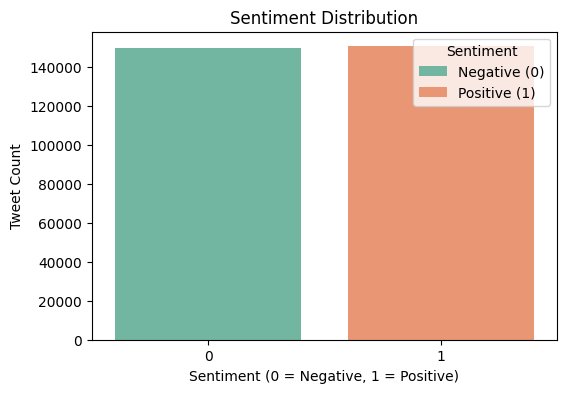

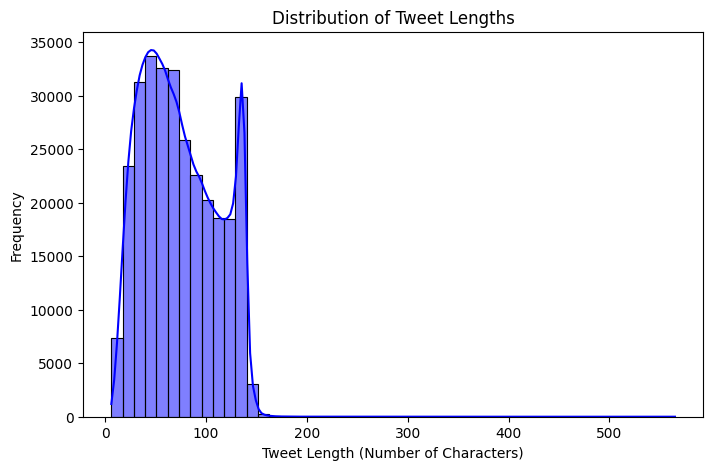

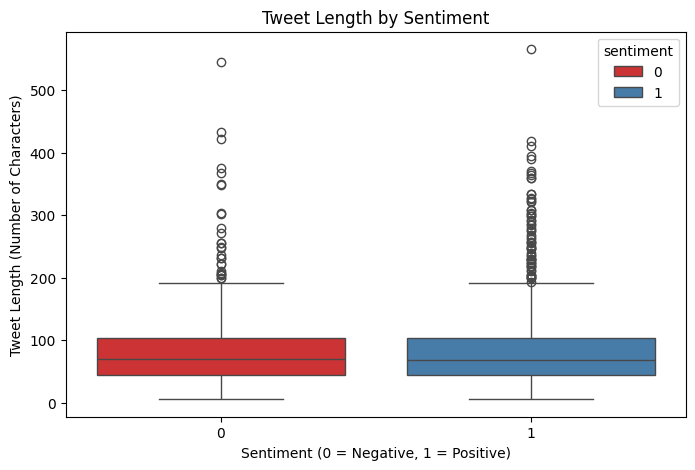

In [44]:
# Plot sentiment distribution with different colors
plt.figure(figsize=(6, 4))
sns.countplot(x="sentiment", data=df_selected, hue="sentiment", palette="Set2")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment (0 = Negative, 1 = Positive)")
plt.ylabel("Tweet Count")
plt.legend(title="Sentiment", labels=["Negative (0)", "Positive (1)"])  #
plt.show()

# Plot the length distribution of tweets (in number of characters)
df_selected["tweet_length"] = df_selected["text"].apply(len)
plt.figure(figsize=(8, 5))
sns.histplot(df_selected["tweet_length"], bins=50, kde=True, color="blue")
plt.title("Distribution of Tweet Lengths")
plt.xlabel("Tweet Length (Number of Characters)")
plt.ylabel("Frequency")
plt.show()

# Plot a boxplot for tweet lengths by sentiment with a palette
plt.figure(figsize=(8, 5))
sns.boxplot(
    x="sentiment", y="tweet_length", hue="sentiment", data=df_selected, palette="Set1"
)
plt.title("Tweet Length by Sentiment")
plt.xlabel("Sentiment (0 = Negative, 1 = Positive)")
plt.ylabel("Tweet Length (Number of Characters)")
plt.show()

## 2. Cleaning and Pre-processing

In [45]:
def clean_text(text):
    text = text.lower()  # Lowercasing
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove @mentions
    text = re.sub(r"#\w+", "", text)  # Remove hashtags
    text = re.sub(r"[^a-z\s]", "", text)  # Remove punctuation and special characters
    return text

In [46]:
# Apply text cleaning function
df_selected["cleaned_text"] = df_selected["text"].apply(clean_text)

In [47]:
sentences = []
for text in df_selected["cleaned_text"]:
    sentences.append(
        text.split()
    )  # Tokenize each sentence and append it to the sentences list

In [48]:
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

# Create a tokenizer to map words to integers (keeping Word2Vec vocab size)
word_index = {}
for i, word in enumerate(word2vec_model.wv.index_to_key):
    word_index[word] = i + 1

In [49]:
# Convert text to sequences (like Keras's texts_to_sequences)
sequences = []
for sentence in sentences:
    word_sequence = []
    for word in sentence:
        word_sequence.append(word_index.get(word, 0))
    sequences.append(word_sequence)

In [50]:
# Print part of the word index
print("Word Index example (first 10 words):")
print(list(word_index.items())[:10])

Word Index example (first 10 words):
[('i', 1), ('to', 2), ('the', 3), ('a', 4), ('my', 5), ('and', 6), ('you', 7), ('is', 8), ('it', 9), ('for', 10)]


In [51]:
print("\nSample sequences:")
for i in range(3):  # Show first 3 sequences as examples
    print(f"Original text: {df_selected['cleaned_text'].iloc[i]}")
    print(f"Tokenized sequence: {sequences[i]}")
    print("-" * 50)


Sample sequences:
Original text:  ahhh i hope your ok 
Tokenized sequence: [858, 1, 93, 41, 179]
--------------------------------------------------
Original text:  cool  i have no tweet apps  for my razr 
Tokenized sequence: [197, 1, 17, 37, 241, 1842, 10, 5, 20401]
--------------------------------------------------
Original text:  i know  just family drama its lamehey next time u hang out with kim n u guys like have a sleepover or whatever ill call u
Tokenized sequence: [1, 59, 20, 369, 1650, 24, 0, 149, 51, 54, 659, 33, 21, 2408, 254, 54, 195, 35, 17, 4, 3924, 99, 1000, 97, 325, 54]
--------------------------------------------------


In [52]:
max_length = 100  # maximum sequence length
X = pad_sequences(sequences, maxlen=max_length)

# embedding matrix
embedding_dim = word2vec_model.vector_size
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# Prepare the labels
y = df_selected["sentiment"].values

print(df_selected[["text", "cleaned_text"]].sample(5))  # sample 5 rows
print("\nTokenized and padded sequences shape:", X.shape)

                                                     text  \
218592  Had a good time at drus. Talked about stuff, w...   
46711   Loving the fact I can finally wear my sundress...   
189695                                Goodnight everyone    
189330                            Bank holiday paradise!    
210627  @amnith operalink was actually turned off afte...   

                                             cleaned_text  
218592  had a good time at drus talked about stuff wat...  
46711   loving the fact i can finally wear my sundresses   
189695                                goodnight everyone   
189330                             bank holiday paradise   
210627   operalink was actually turned off after the u...  

Tokenized and padded sequences shape: (300000, 100)


In [53]:
input_dim = len(word_index) + 1  # Input dimension (size of vocab + 1 for padding token)
output_dim = embedding_dim
print(f"Input dimension (vocabulary size): {input_dim}")

Input dimension (vocabulary size): 43727


In [54]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Function to plot a word cloud
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
        " ".join(text)
    )

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

In [55]:
# Separate the positive and negative sentiment texts
positive_text = df_selected[df_selected["sentiment"] == 1]["cleaned_text"]
negative_text = df_selected[df_selected["sentiment"] == 0]["cleaned_text"]

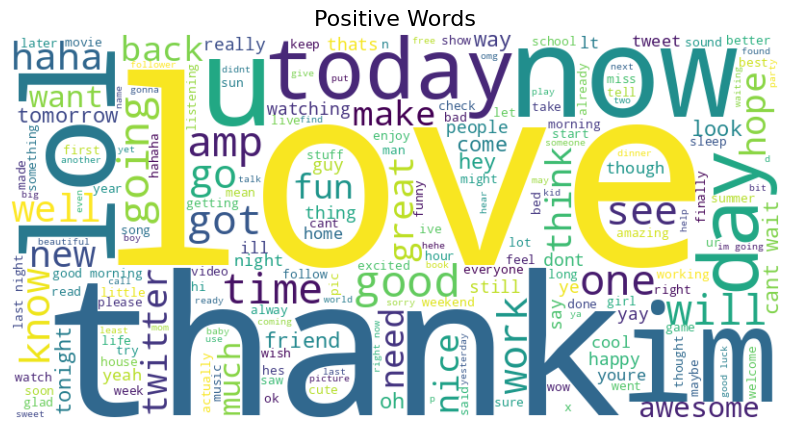

In [56]:
plot_wordcloud(positive_text, "Positive Words")

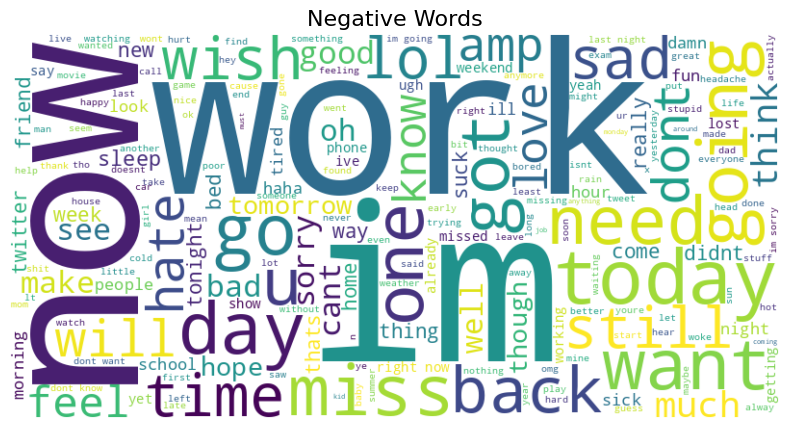

In [57]:
plot_wordcloud(negative_text, "Negative Words")

In [58]:
# Split the data into training+validation and testing sets (80% train+val, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Split the training+validation set into training and validation sets (75% train, 25% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42
)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (180000, 100) (180000,)
Validation set shape: (60000, 100) (60000,)
Test set shape: (60000, 100) (60000,)


In [59]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0.01,
    patience=3,
    verbose=1,
    mode="min",
    restore_best_weights=True,
)

# B. Model Implementation

## 1. CNN Model

In [60]:
# CNN Model
cnn_model = Sequential(
    [
        Input(shape=(max_length,)),  # Input layer
        Embedding(
            input_dim=input_dim,
            output_dim=output_dim,
            weights=[embedding_matrix],
            trainable=True,
        ),  # Word2Vec embeddings
        Conv1D(filters=32, kernel_size=3, activation="relu"),  # Apply 1D convolution
        GlobalMaxPooling1D(),  # Pooling layer to reduce dimensionality
        Dense(10, activation="relu"),  # Fully connected layer
        Dense(1, activation="sigmoid"),  # Output layer for binary classification
    ]
)

# Compile the model
cnn_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
cnn_model.summary()

2024-10-12 14:42:56.655584: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-10-12 14:42:56.658786: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-10-12 14:42:56.662804: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-10-12 14:42:56.666993: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-12 14:42:56.671434: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │     4,372,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 98, 32)         │         9,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,382,673 (16.72 MB)

 Trainable params: 4,382,673 (16.72 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
# Train the CNN model by fitting the training data and inputing the batch size and number of epochs.
batch_size_cnn = 32
epochs_cnn = 5
history_cnn_model = cnn_model.fit(
    X_train,
    y_train,
    batch_size=batch_size_cnn,
    epochs=epochs_cnn,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
)  # Apply early stopping when validation loss increases

Epoch 1/5


2024-10-12 14:42:59.983126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


5625/5625 ━━━━━━━━━━━━━━━━━━━━ 175s 31ms/step - accuracy: 0.7385 - loss: 0.5197 - val_accuracy: 0.7858 - val_loss: 0.4541
Epoch 2/5
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 168s 30ms/step - accuracy: 0.8093 - loss: 0.4132 - val_accuracy: 0.7967 - val_loss: 0.4356
Epoch 3/5
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 172s 31ms/step - accuracy: 0.8357 - loss: 0.3696 - val_accuracy: 0.7960 - val_loss: 0.4414
Epoch 4/5
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 160s 28ms/step - accuracy: 0.8599 - loss: 0.3255 - val_accuracy: 0.7912 - val_loss: 0.4557
Epoch 5/5
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 164s 29ms/step - accuracy: 0.8783 - loss: 0.2883 - val_accuracy: 0.7908 - val_loss: 0.4796
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


In [62]:
# Test the model's performance to the test dataset.
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(X_test, y_test)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8017 - loss: 0.4302


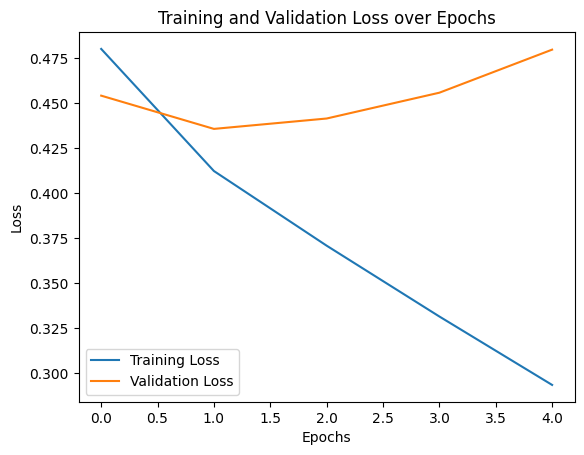

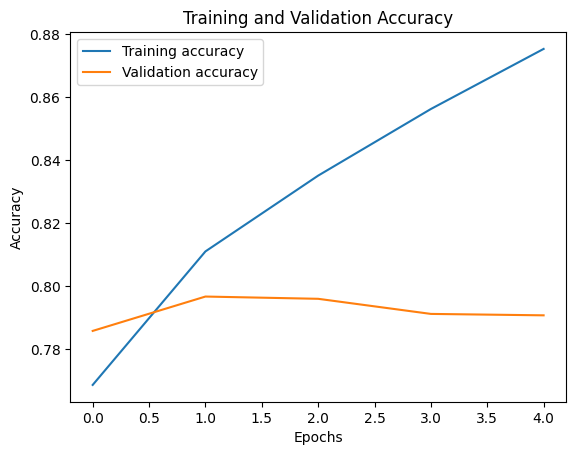

In [63]:
# Plot Training and Validation Loss
plt.plot(history_cnn_model.history["loss"], label="Training Loss")
plt.plot(history_cnn_model.history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot Training and Validation Accuracy
plt.plot(history_cnn_model.history["accuracy"], label="Training accuracy")
plt.plot(history_cnn_model.history["val_accuracy"], label="Validation accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [64]:
# Randomly sample indices from your test set (X_test)
sample_indices = np.random.choice(
    len(X_test), 5, replace=False
)  # Randomly pick 5 samples

# Extract the original sentences corresponding to the original DataFrame
sample_sentences = df_selected["cleaned_text"].iloc[sample_indices].tolist()

# Extract the corresponding preprocessed sequences
sample_padded = X_test[sample_indices]

In [65]:
# Predict the sentiment for these preprocessed sample sequences
predictions_cnn = cnn_model.predict(sample_padded)
for i, sentence in enumerate(sample_sentences):
    predicted_sentiment = "Positive" if predictions_cnn[i] > 0.5 else "Negative"
    print(f"Sentence: {sentence}")
    print(f"Predicted Sentiment: {predicted_sentiment}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step
Sentence:  so a little wired sonya lol 
Predicted Sentiment: Positive

Sentence:  aww well thankyou  im glad you like them
Predicted Sentiment: Negative

Sentence:  saw yall talkin about it so i took a look bravo   youve captured princess tamis essence    
Predicted Sentiment: Positive

Sentence: awesome night diner and a movie with my boy thanks for a great time baby hitting up the lake tomorrow  good night my twitter friends
Predicted Sentiment: Positive

Sentence: probando tweetie excelente 
Predicted Sentiment: Positive



## 2. Bi-LSTM Model

In [66]:
# BiLSTM model
bilstm_model = Sequential(
    [
        Input(shape=(max_length,)),
        Embedding(
            input_dim=input_dim,
            output_dim=output_dim,
            weights=[embedding_matrix],
            trainable=True,
        ),  # Word2Vec embeddings
        Bidirectional(LSTM(128, return_sequences=False)),
        Dropout(0.5),
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(1, activation="sigmoid"),
    ]
)

# Compile the model
bilstm_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
bilstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 100)       │     4,372,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,640,221 (17.70 MB)

 Trainable params: 4,640,221 (17.70 MB)

 Non-trainable params: 0 (0.00 B)

In [67]:
# Train the Bi-LSTM model by fitting the training data and inputing the batch size and number of epochs.
batch_size_bilstm = 32
epochs_bilstm = 5
history_bilstm_model = bilstm_model.fit(
    X_train,
    y_train,
    batch_size=batch_size_bilstm,
    epochs=epochs_bilstm,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
)

Epoch 1/5
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 458s 81ms/step - accuracy: 0.7564 - loss: 0.4990 - val_accuracy: 0.8041 - val_loss: 0.4251
Epoch 2/5
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 452s 80ms/step - accuracy: 0.8295 - loss: 0.3858 - val_accuracy: 0.8026 - val_loss: 0.4240
Epoch 3/5
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 453s 81ms/step - accuracy: 0.8585 - loss: 0.3289 - val_accuracy: 0.8025 - val_loss: 0.4548
Epoch 4/5
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 440s 78ms/step - accuracy: 0.8839 - loss: 0.2761 - val_accuracy: 0.7936 - val_loss: 0.4984
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


In [68]:
# Test the model's performance to the test dataset.
bilstm_test_loss, bilstm_test_acc = bilstm_model.evaluate(X_test, y_test)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 40s 21ms/step - accuracy: 0.8086 - loss: 0.4181


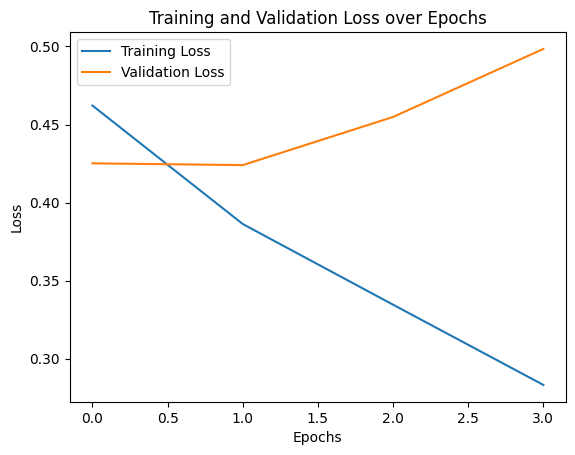

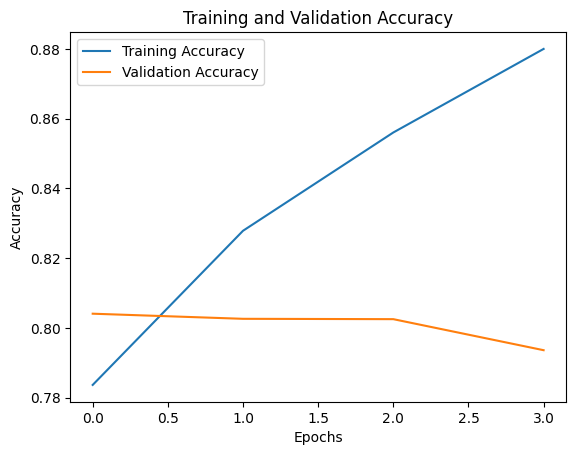

In [69]:
# Plot the training and validation loss
plt.plot(history_bilstm_model.history["loss"], label="Training Loss")
plt.plot(history_bilstm_model.history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


# Plot Training and Validation Accuracy
plt.plot(history_bilstm_model.history["accuracy"], label="Training Accuracy")
plt.plot(history_bilstm_model.history["val_accuracy"], label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [70]:
# Predict the sample sentiment
predictions_bilstm = bilstm_model.predict(sample_padded)

for i, sentence in enumerate(sample_sentences):
    predicted_sentiment = "Positive" if predictions_bilstm[i] > 0.5 else "Negative"
    print(f"Sentence: {sentence}")
    print(f"Predicted Sentiment: {predicted_sentiment}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Sentence:  so a little wired sonya lol 
Predicted Sentiment: Positive

Sentence:  aww well thankyou  im glad you like them
Predicted Sentiment: Negative

Sentence:  saw yall talkin about it so i took a look bravo   youve captured princess tamis essence    
Predicted Sentiment: Positive

Sentence: awesome night diner and a movie with my boy thanks for a great time baby hitting up the lake tomorrow  good night my twitter friends
Predicted Sentiment: Negative

Sentence: probando tweetie excelente 
Predicted Sentiment: Positive



## 3. RNN-GRU

In [71]:
# GRU Model
gru_model = Sequential(
    [
        Input(shape=(max_length,)),
        Embedding(
            input_dim=input_dim,
            output_dim=output_dim,
            weights=[embedding_matrix],
            trainable=True,
        ),
        GRU(32, return_sequences=True),
        GRU(16, return_sequences=False),
        Dense(10, activation="relu"),
        Dense(1, activation="sigmoid"),
    ]
)

# Compile the model
gru_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
gru_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 100)       │     4,372,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 100, 32)        │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 16)             │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,388,145 (16.74 MB)

 Trainable params: 4,388,145 (16.74 MB)

 Non-trainable params: 0 (0.00 B)

In [72]:
batch_size_gru = 32
epochs_gru = 5
history_gru_model = gru_model.fit(
    X_train,
    y_train,
    batch_size=batch_size_gru,
    epochs=epochs_gru,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
)

Epoch 1/5
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 232s 41ms/step - accuracy: 0.7610 - loss: 0.4881 - val_accuracy: 0.8039 - val_loss: 0.4220
Epoch 2/5
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 244s 43ms/step - accuracy: 0.8366 - loss: 0.3675 - val_accuracy: 0.8040 - val_loss: 0.4243
Epoch 3/5
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 243s 43ms/step - accuracy: 0.8702 - loss: 0.3022 - val_accuracy: 0.7936 - val_loss: 0.4644
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.


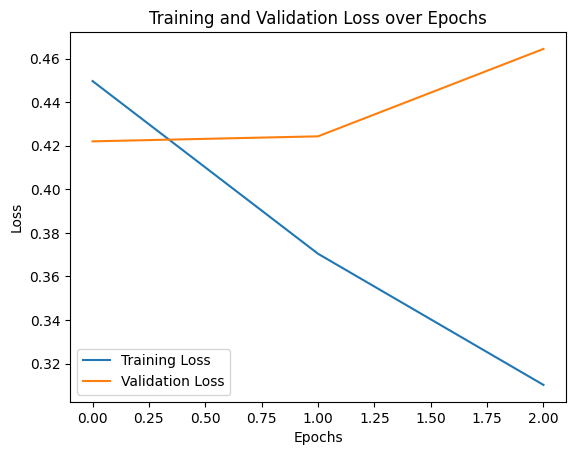

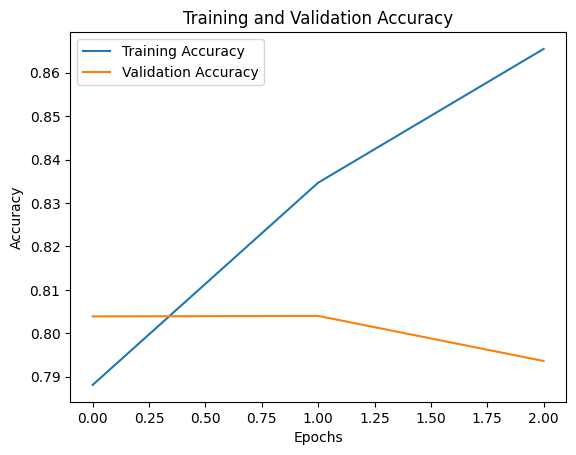

In [73]:
# Plot the training and validation loss
plt.plot(history_gru_model.history["loss"], label="Training Loss")
plt.plot(history_gru_model.history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


# Plot Training and Validation Accuracy
plt.plot(history_gru_model.history["accuracy"], label="Training Accuracy")
plt.plot(history_gru_model.history["val_accuracy"], label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [74]:
# Predict the sentiment for these preprocessed sample sequences
predictions_gru = gru_model.predict(sample_padded)
for i, sentence in enumerate(sample_sentences):
    predicted_sentiment = "Positive" if predictions_cnn[i] > 0.5 else "Negative"
    print(f"Sentence: {sentence}")
    print(f"Predicted Sentiment: {predicted_sentiment}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 933ms/step
Sentence:  so a little wired sonya lol 
Predicted Sentiment: Positive

Sentence:  aww well thankyou  im glad you like them
Predicted Sentiment: Negative

Sentence:  saw yall talkin about it so i took a look bravo   youve captured princess tamis essence    
Predicted Sentiment: Positive

Sentence: awesome night diner and a movie with my boy thanks for a great time baby hitting up the lake tomorrow  good night my twitter friends
Predicted Sentiment: Positive

Sentence: probando tweetie excelente 
Predicted Sentiment: Positive



In [75]:
# Test the model's performance to the test dataset.
gru_test_loss, gru_test_acc = gru_model.evaluate(X_test, y_test)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8083 - loss: 0.4162


# C. Hyperparameters Finetuning

The code for hyperparameters tuning (using grid search) has been commented, to reduce the computational time to run all the code. The results of the hyperparameters tuning are located in the **appendix** of the report.

## 1. CNN Hypertuning

In [76]:
# from sklearn.metrics import accuracy_score

# param_grid = {
#     'embedding_dim': [word2vec_model.vector_size],  # Example values for embedding dimensions
#     'filters': [16, 32, 64],
#     'kernel_size': [2, 3, 5],
#     'dense_units': [10, 20]
# }

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# best_score = 0
# best_params = {}

# # Iterate over all combinations of parameters
# for embedding_dim in param_grid['embedding_dim']:
#     for filters in param_grid['filters']:
#         for kernel_size in param_grid['kernel_size']:
#             for dense_units in param_grid['dense_units']:
#                 print(f'Testing params: embedding_dim={embedding_dim}, filters={filters}, kernel_size={kernel_size}, dense_units={dense_units}')

#                 # Train the model
#                 cnn_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)  # You can adjust epochs and batch_size

#                 # Evaluate the model
#                 y_val_pred = cnn_model.predict(X_val)
#                 y_val_pred_classes = (y_val_pred > 0.5).astype(int)  # Convert probabilities to binary predictions
#                 score = accuracy_score(y_val, y_val_pred_classes)

#                 print(f'Validation Accuracy: {score}')

#                 # Check if this is the best score
#                 if score > best_score_cnn:
#                     best_score_cnn = score
#                     best_params_cnn = {
#                         'embedding_dim': embedding_dim,
#                         'filters': filters,
#                         'kernel_size': kernel_size,
#                         'dense_units': dense_units
#                     }

# print(f'Best Score: {best_score_cnn} using {best_params_cnn}')

Best params = {'embedding_dim': 100,'filters': 16,'kernel_size': 3,'dense_units': 20}

## 2. Bi-LSTM Hypertuning

In [77]:
# # hyperparameters to tune
# param_grid = {
#     'lstm_units': [64, 128],
#     'dense_units': [64, 128],
#     'dropout_rate': [0.3, 0.5]
# }

# best_score = 0
# best_params = {}

# # Iterate over all combinations of hyperparameters
# for lstm_units in param_grid['lstm_units']:
#     for dense_units in param_grid['dense_units']:
#         for dropout_rate in param_grid['dropout_rate']:
#             print(f'Testing params: lstm_units={lstm_units}, dense_units={dense_units}, dropout_rate={dropout_rate}')

#             # Train the model
#             bilstm_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)  # Adjust epochs and batch_size as needed

#             # Evaluate the model on the validation set
#             y_val_pred_prob = bilstm_model.predict(X_val)
#             y_val_pred = (y_val_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions
#             score = accuracy_score(y_val, y_val_pred)

#             print(f'Validation Accuracy: {score}')

#             # Check if this is the best score
#             if score > best_score_bilstm:
#                 best_score_bilstm = score
#                 best_params_bilstm = {
#                     'lstm_units': lstm_units,
#                     'dense_units': dense_units,
#                     'dropout_rate': dropout_rate
#                 }

# print(f'Best Score: {best_score_bilstm} using {best_params_bilstm}')

Best Params {'lstm_units': 64, 'dense_units': 64, 'dropout_rate': 0.3}

## 3. RNN-GRU Hypertuning

In [78]:
# param_grid = {
#     'gru_units1': [32, 64, 128],
#     'gru_units2': [16, 32, 64],
#     'dense_units': [10, 20, 30]
# }

# best_score = 0
# best_params = {}

# # Iterate over all combinations of hyperparameters
# for gru_units1 in param_grid['gru_units1']:
#     for gru_units2 in param_grid['gru_units2']:
#         for dense_units in param_grid['dense_units']:
#             print(f'Testing params: gru_units1={gru_units1}, gru_units2={gru_units2}, dense_units={dense_units}')


#             gru_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)  # Adjust epochs and batch_size as needed

#             # Evaluate the model on the validation set
#             y_val_pred_prob = gru_model.predict(X_val)
#             y_val_pred = (y_val_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions
#             score = accuracy_score(y_val, y_val_pred)

#             print(f'Validation Accuracy: {score}')

#             # Check if this is the best score
#             if score > best_score_gru:
#                 best_score_gru = score
#                 best_params_gru = {
#                     'gru_units1': gru_units1,
#                     'gru_units2': gru_units2,
#                     'dense_units': dense_units
#                 }

# print(f'Best Score: {best_score_gru} using {best_params_gru}')

Best Params {'gru_units1': 32, 'gru_units2': 16, 'dense_units': 10}

# D. Evaluation

## 1. CNN Base

In [79]:
y_pred = cnn_model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")


# Print the accuracy, precision, recall, and F1-score
accuracy_cnn = accuracy_score(y_test, y_pred_classes)
precision_cnn = precision_score(y_test, y_pred_classes, average="binary")
recall_cnn = recall_score(y_test, y_pred_classes, average="binary")
f1_cnn = f1_score(y_test, y_pred_classes, average="binary")

print(f"Accuracy: {accuracy_cnn}")
print(f"Precision: {precision_cnn}")
print(f"Recall: {recall_cnn}")
print(f"F1-score: {f1_cnn}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_classes))

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Accuracy: 0.8009666666666667
Precision: 0.8022977819099482
Recall: 0.8013930348258707
F1-score: 0.801845153154349

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80     29850
           1       0.80      0.80      0.80     30150

    accuracy                           0.80     60000
   macro avg       0.80      0.80      0.80     60000
weighted avg       0.80      0.80      0.80     60000



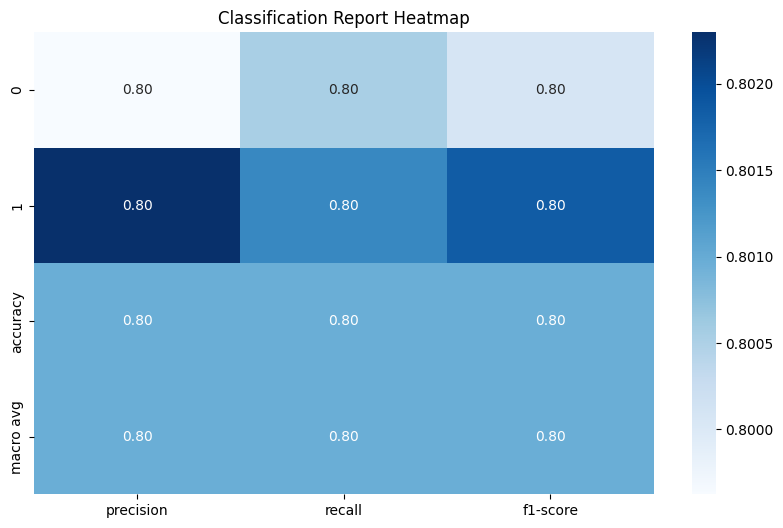

In [80]:
cnn_dict = classification_report(y_test, y_pred_classes, output_dict=True)
cnn_report = pd.DataFrame(cnn_dict).transpose()

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cnn_report.iloc[:-1, :-1], annot=True, cmap="Blues", fmt=".2f")
plt.title("Classification Report Heatmap")
plt.show()

## 2. CNN Hypertuned

In [81]:
# params = {'embedding_dim': 100,'filters': 16,'kernel_size': 3,'dense_units': 20}

# CNN Model Hypertuned
cnn_model_hypertuned = Sequential(
    [
        Input(shape=(max_length,)),
        Embedding(
            input_dim=input_dim,
            output_dim=output_dim,
            weights=[embedding_matrix],
            trainable=True,
        ),
        Conv1D(filters=16, kernel_size=3, activation="relu"),
        GlobalMaxPooling1D(),
        Dense(20, activation="relu"),
        Dense(1, activation="sigmoid"),
    ]
)
cnn_model_hypertuned.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)

# Train the hypertuned model
cnn_model_hypertuned.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
)
y_pred = cnn_model_hypertuned.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")


# Print the accuracy, precision, recall, and F1-score
accuracy_cnn_hypertuned = accuracy_score(y_test, y_pred_classes)
precision_cnn_hypertuned = precision_score(y_test, y_pred_classes, average="binary")
recall_cnn_hypertuned = recall_score(y_test, y_pred_classes, average="binary")
f1_cnn_hypertuned = f1_score(y_test, y_pred_classes, average="binary")

print(f"Accuracy: {accuracy_cnn_hypertuned}")
print(f"Precision: {precision_cnn_hypertuned}")
print(f"Recall: {recall_cnn_hypertuned}")
print(f"F1-score: {f1_cnn_hypertuned}")

print("\nClassification Report:\n", classification_report(y_test, y_pred_classes))

Epoch 1/5
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 170s 30ms/step - accuracy: 0.7306 - loss: 0.5295 - val_accuracy: 0.7822 - val_loss: 0.4611
Epoch 2/5
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 165s 29ms/step - accuracy: 0.8043 - loss: 0.4215 - val_accuracy: 0.7928 - val_loss: 0.4397
Epoch 3/5
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 164s 29ms/step - accuracy: 0.8284 - loss: 0.3811 - val_accuracy: 0.7936 - val_loss: 0.4409
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Accuracy: 0.7846833333333333
Precision: 0.763124942735852
Recall: 0.8287562189054727
F1-score: 0.7945876329639229

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.74      0.77     29850
           1       0.76      0.83      0.79     30150

    accuracy                           0.78     60000
   macro avg       0.79      0.78      0.78     60000
weighted avg       0.79      0.78      0.78     60000



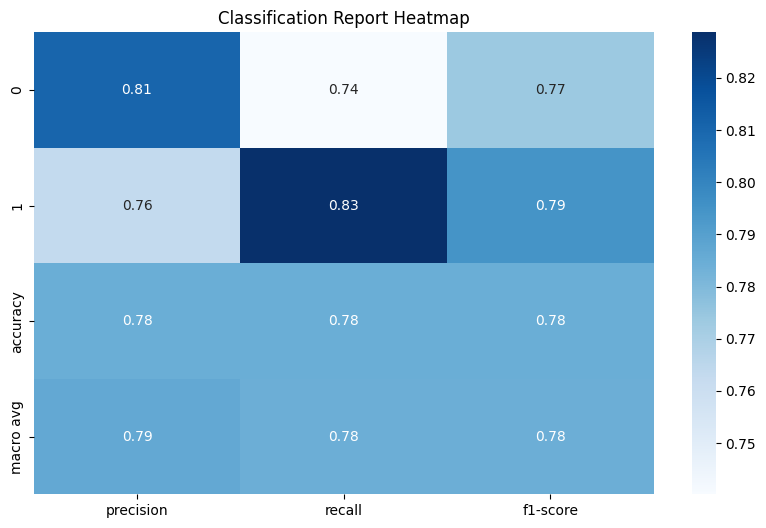

In [82]:
cnn_hypertuned_dict = classification_report(y_test, y_pred_classes, output_dict=True)
cnn_hypertuned_report = pd.DataFrame(cnn_hypertuned_dict).transpose()

plt.figure(figsize=(10, 6))
sns.heatmap(cnn_hypertuned_report.iloc[:-1, :-1], annot=True, cmap="Blues", fmt=".2f")
plt.title("Classification Report Heatmap")
plt.show()

## 3. Bi-LSTM Base

In [83]:
y_pred = bilstm_model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")


accuracy_bilstm = accuracy_score(y_test, y_pred_classes)
precision_bilstm = precision_score(y_test, y_pred_classes)
recall_bilstm = recall_score(y_test, y_pred_classes)
f1_bilstm = f1_score(y_test, y_pred_classes)


# Print the accuracy, precision, recall, and F1-score
print(f"Accuracy: {accuracy_bilstm}")
print(f"Precision: {precision_bilstm}")
print(f"Recall: {recall_bilstm}")
print(f"F1-Score: {f1_bilstm}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_classes))

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step
Accuracy: 0.8075833333333333
Precision: 0.8173290124509637
Recall: 0.7946932006633499
F1-Score: 0.8058521819557724

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.82      0.81     29850
           1       0.82      0.79      0.81     30150

    accuracy                           0.81     60000
   macro avg       0.81      0.81      0.81     60000
weighted avg       0.81      0.81      0.81     60000



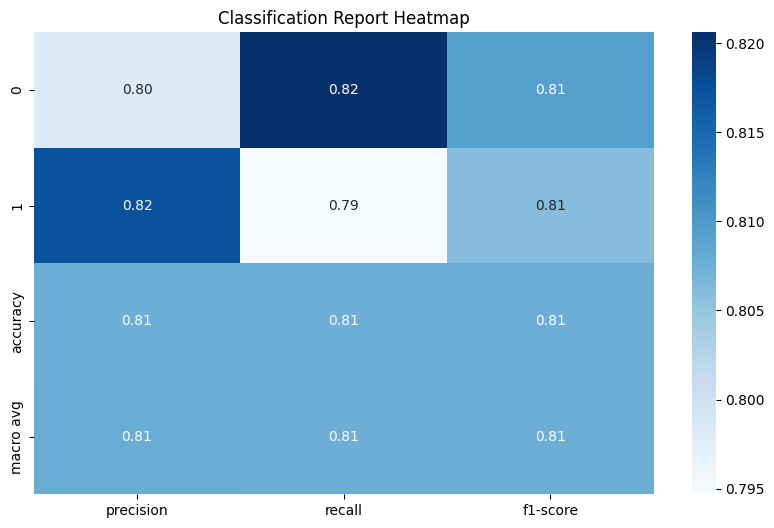

In [84]:
bilstm_dict = classification_report(y_test, y_pred_classes, output_dict=True)
bilstm_report = pd.DataFrame(bilstm_dict).transpose()

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(bilstm_report.iloc[:-1, :-1], annot=True, cmap="Blues", fmt=".2f")
plt.title("Classification Report Heatmap")
plt.show()

## 4. Bi-LSTM Hypertuned

In [85]:
# Params {'lstm_units': 64, 'dense_units': 64, 'dropout_rate': 0.3}

bilstm_model_hypertuned = Sequential(
    [
        Input(shape=(max_length,)),
        Embedding(
            input_dim=input_dim,
            output_dim=output_dim,
            weights=[embedding_matrix],
            trainable=True,
        ),
        Bidirectional(LSTM(64, return_sequences=False)),
        Dropout(0.5),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(1, activation="sigmoid"),
    ]
)
bilstm_model_hypertuned.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)

bilstm_model_hypertuned.fit(
    X_train,
    y_train,
    batch_size=batch_size_bilstm,
    epochs=epochs_bilstm,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
)

y_pred = bilstm_model_hypertuned.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")


accuracy_bilstm_hypertuned = accuracy_score(y_test, y_pred_classes)
precision_bilstm_hypertuned = precision_score(y_test, y_pred_classes)
recall_bilstm_hypertuned = recall_score(y_test, y_pred_classes)
f1_bilstm_hypertuned = f1_score(y_test, y_pred_classes)


# Print the accuracy, precision, recall, and F1-score
print(f"Accuracy: {accuracy_bilstm_hypertuned}")
print(f"Precision: {precision_bilstm_hypertuned}")
print(f"Recall: {recall_bilstm_hypertuned}")
print(f"F1-Score: {f1_bilstm_hypertuned}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_classes))

Epoch 1/5
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 418s 74ms/step - accuracy: 0.7543 - loss: 0.5028 - val_accuracy: 0.8029 - val_loss: 0.4249
Epoch 2/5
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 425s 76ms/step - accuracy: 0.8274 - loss: 0.3892 - val_accuracy: 0.8023 - val_loss: 0.4257
Epoch 3/5
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 414s 74ms/step - accuracy: 0.8538 - loss: 0.3358 - val_accuracy: 0.7972 - val_loss: 0.4463
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step
Accuracy: 0.8049666666666667
Precision: 0.81992230854606
Recall: 0.7840796019900498
F1-Score: 0.8016004882845614

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.83      0.81     29850
           1       0.82      0.78      0.80     30150

    accuracy                           0.80     60000
   macro avg       0.81      0.81      0.80     60000
weighted avg       0.81      0.80      0.80     60000



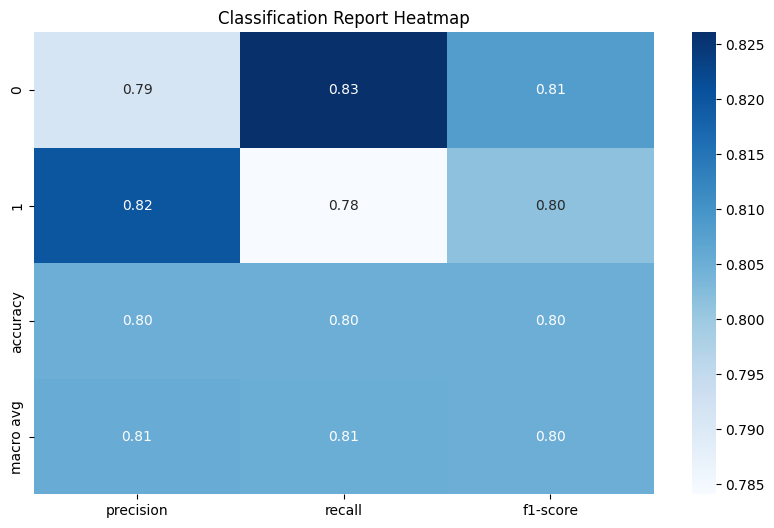

In [86]:
bilstm_hypertuned_dict = classification_report(y_test, y_pred_classes, output_dict=True)
bilstm_hypertuned_report = pd.DataFrame(bilstm_hypertuned_dict).transpose()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    bilstm_hypertuned_report.iloc[:-1, :-1], annot=True, cmap="Blues", fmt=".2f"
)
plt.title("Classification Report Heatmap")
plt.show()

## 5. RNN-GRU Base

In [87]:
y_pred = gru_model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

accuracy_gru = accuracy_score(y_test, y_pred_classes)
precision_gru = precision_score(y_test, y_pred_classes, average="weighted")
recall_gru = recall_score(y_test, y_pred_classes, average="weighted")
f1_gru = f1_score(y_test, y_pred_classes, average="weighted")

# Print the accuracy, precision, recall, and F1-score

print(f"Accuracy: {accuracy_gru}")
print(f"Precision: {precision_gru}")
print(f"Recall: {recall_gru}")
print(f"F1 Score: {f1_gru}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_classes))

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step
Accuracy: 0.8081666666666667
Precision: 0.8082956535437669
Recall: 0.8081666666666667
F1 Score: 0.8081327224108775

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.80      0.81     29850
           1       0.80      0.82      0.81     30150

    accuracy                           0.81     60000
   macro avg       0.81      0.81      0.81     60000
weighted avg       0.81      0.81      0.81     60000



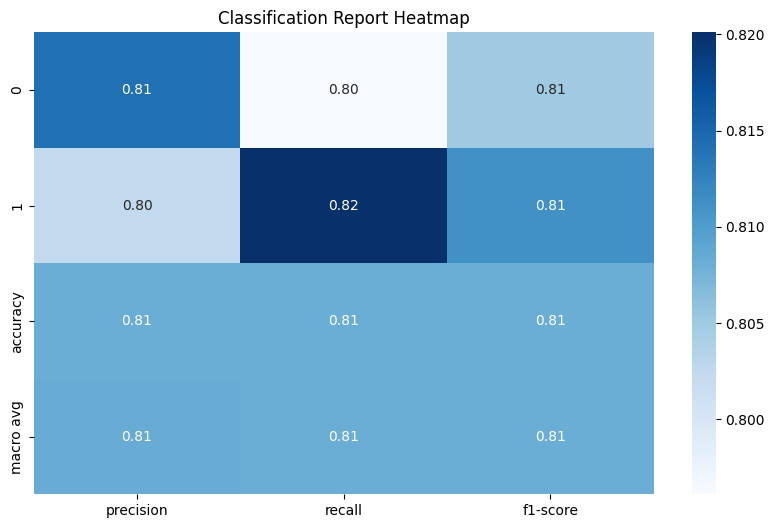

In [88]:
gru_dict = classification_report(y_test, y_pred_classes, output_dict=True)
gru_report = pd.DataFrame(gru_dict).transpose()

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(gru_report.iloc[:-1, :-1], annot=True, cmap="Blues", fmt=".2f")
plt.title("Classification Report Heatmap")
plt.show()

## 6. RNN-GRU Hypertuned

In [95]:
# Params {'gru_units1': 32, 'gru_units2': 16, 'dense_units': 10}

# GRU Model
gru_model_hypertuned = Sequential(
    [
        Input(shape=(max_length,)),
        Embedding(
            input_dim=input_dim,
            output_dim=output_dim,
            weights=[embedding_matrix],
            trainable=True,
        ),
        GRU(32, return_sequences=True),
        GRU(16, return_sequences=False),
        Dense(10, activation="relu"),
        Dense(1, activation="sigmoid"),
    ]
)

gru_model_hypertuned.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)
gru_model_hypertuned.fit(
    X_train,
    y_train,
    batch_size=batch_size_bilstm,
    epochs=epochs_bilstm,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
)
y_pred = gru_model_hypertuned.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

accuracy_gru_hypertuned = accuracy_score(y_test, y_pred_classes)
precision_gru_hypertuned = precision_score(y_test, y_pred_classes, average="weighted")
recall_gru_hypertuned = recall_score(y_test, y_pred_classes, average="weighted")
f1_gru_hypertuned = f1_score(y_test, y_pred_classes, average="weighted")

# Print the accuracy, precision, recall, and F1-score
print(f"Accuracy: {accuracy_gru_hypertuned}")
print(f"Precision: {precision_gru_hypertuned}")
print(f"Recall: {recall_gru_hypertuned}")
print(f"F1 Score: {f1_gru_hypertuned}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_classes))

Epoch 1/5
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 219s 38ms/step - accuracy: 0.7611 - loss: 0.4872 - val_accuracy: 0.7979 - val_loss: 0.4293
Epoch 2/5
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 217s 39ms/step - accuracy: 0.8353 - loss: 0.3683 - val_accuracy: 0.8031 - val_loss: 0.4278
Epoch 3/5
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 220s 39ms/step - accuracy: 0.8676 - loss: 0.3067 - val_accuracy: 0.7941 - val_loss: 0.4681
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step
Accuracy: 0.8011166666666667
Precision: 0.8033123750726243
Recall: 0.8011166666666667
F1 Score: 0.8006988358968999

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.76      0.79     29850
           1       0.78      0.85      0.81     30150

    accuracy                           0.80     60000
   macro avg       0.80      0.80      0.80     60000
weighted avg       0.80      0.80      0.80     60000



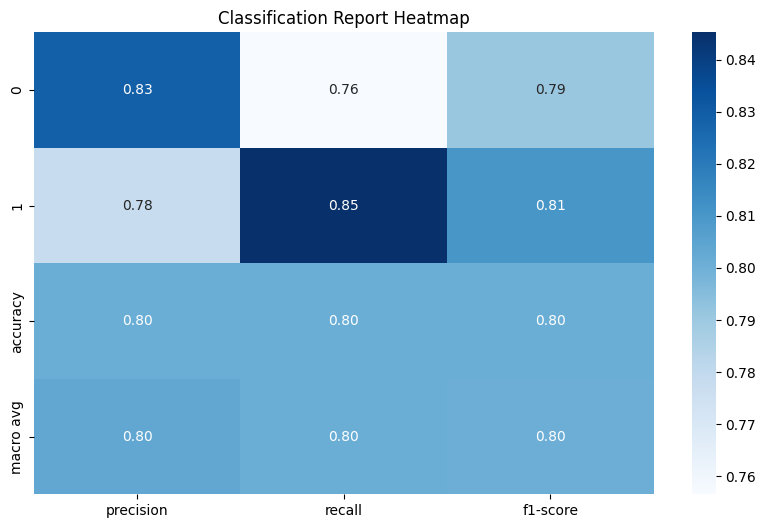

In [96]:
gru_hypertuned_dict = classification_report(y_test, y_pred_classes, output_dict=True)
gru_hypertuned_report = pd.DataFrame(gru_hypertuned_dict).transpose()

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(gru_hypertuned_report.iloc[:-1, :-1], annot=True, cmap="Blues", fmt=".2f")
plt.title("Classification Report Heatmap")
plt.show()

# E. Comparison

## 1. Accuracy Comparison

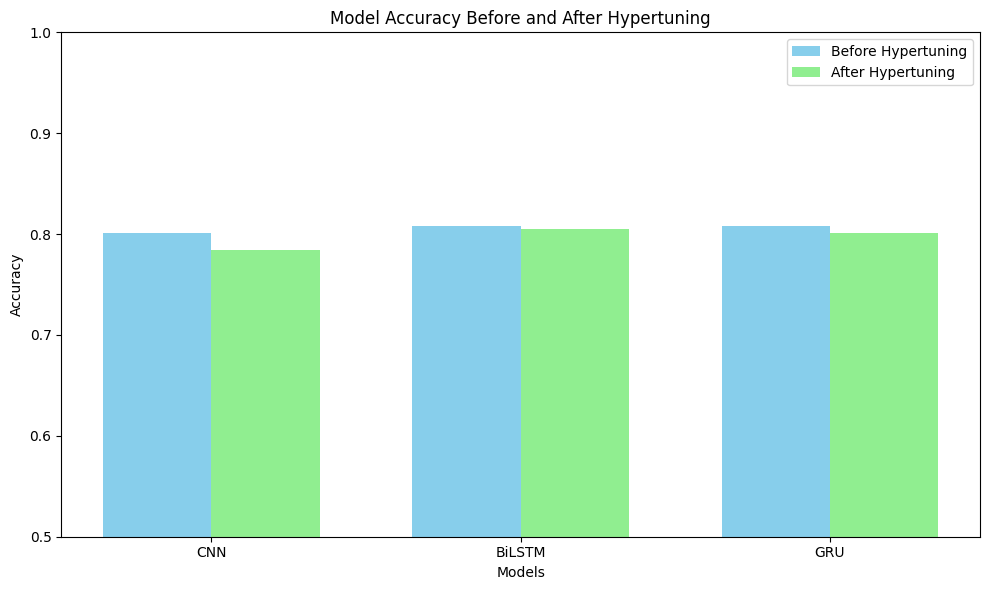

In [97]:
models = ["CNN", "BiLSTM", "GRU"]
# Accuracy before and after hypertuning
accuracy_before = [accuracy_cnn, accuracy_bilstm, accuracy_gru]
accuracy_after = [
    accuracy_cnn_hypertuned,
    accuracy_bilstm_hypertuned,
    accuracy_gru_hypertuned,
]
x = np.arange(len(models))
bar_width = 0.35

plt.figure(figsize=(10, 6))

bars_before = plt.bar(
    x - bar_width / 2,
    accuracy_before,
    bar_width,
    label="Before Hypertuning",
    color="skyblue",
)
bars_after = plt.bar(
    x + bar_width / 2,
    accuracy_after,
    bar_width,
    label="After Hypertuning",
    color="lightgreen",
)

# Add labels, title, and legend
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Before and After Hypertuning")
plt.xticks(x, models)
plt.ylim(0.5, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

## 2. Precision Comparison

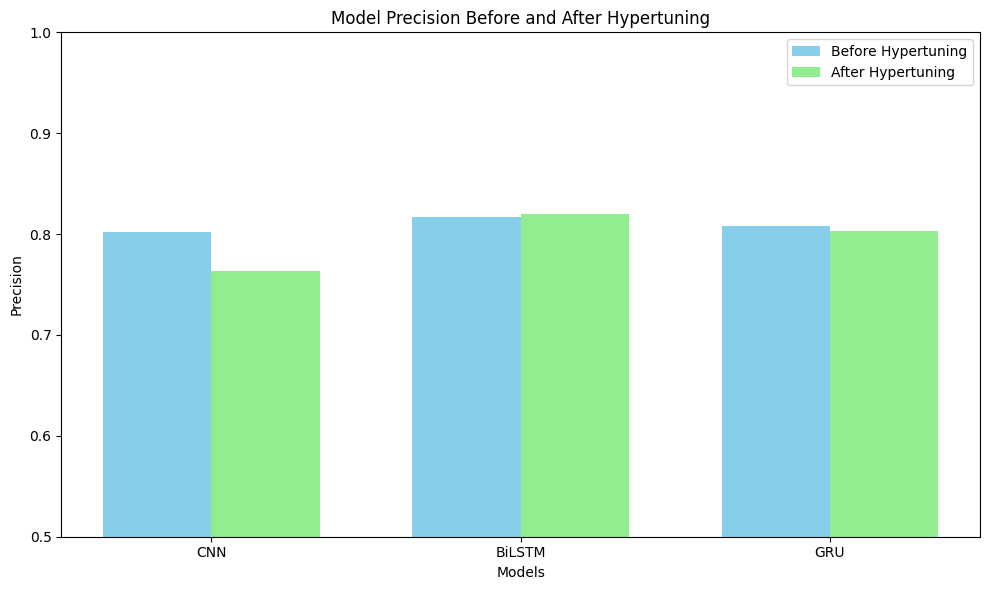

In [98]:
models = ["CNN", "BiLSTM", "GRU"]
# Precision before and after hypertuning
precision_before = [precision_cnn, precision_bilstm, precision_gru]
precision_after = [
    precision_cnn_hypertuned,
    precision_bilstm_hypertuned,
    precision_gru_hypertuned,
]
x = np.arange(len(models))
bar_width = 0.35
plt.figure(figsize=(10, 6))

bars_before = plt.bar(
    x - bar_width / 2,
    precision_before,
    bar_width,
    label="Before Hypertuning",
    color="skyblue",
)
bars_after = plt.bar(
    x + bar_width / 2,
    precision_after,
    bar_width,
    label="After Hypertuning",
    color="lightgreen",
)

# Add labels, title, and legend
plt.xlabel("Models")
plt.ylabel("Precision")
plt.title("Model Precision Before and After Hypertuning")
plt.xticks(x, models)
plt.ylim(0.5, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

## 3. Recall Comparison

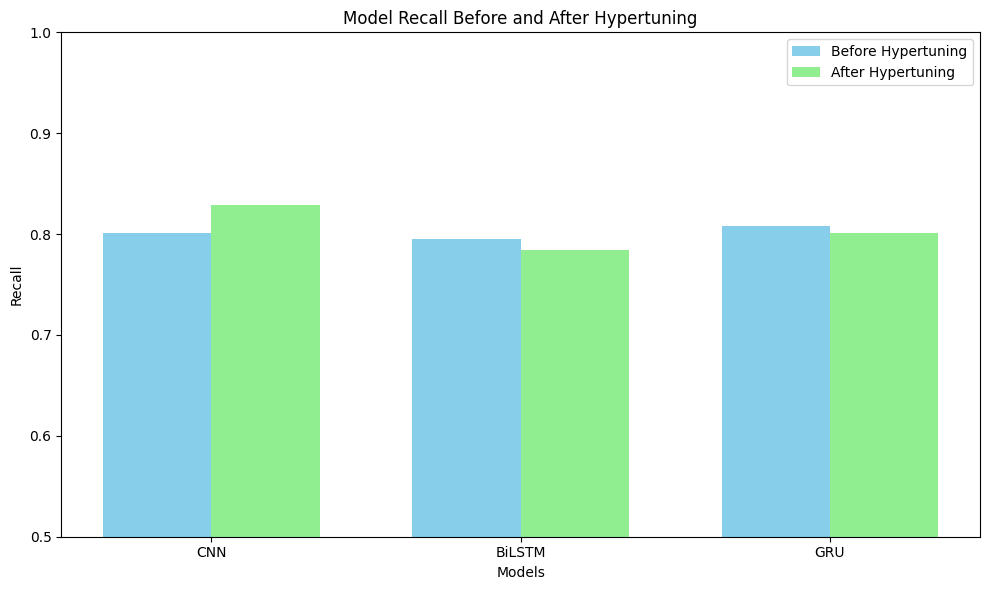

In [99]:
models = ["CNN", "BiLSTM", "GRU"]
# Recall before and after hypertuning
recall_before = [recall_cnn, recall_bilstm, recall_gru]
recall_after = [recall_cnn_hypertuned, recall_bilstm_hypertuned, recall_gru_hypertuned]
x = np.arange(len(models))
bar_width = 0.35
plt.figure(figsize=(10, 6))

bars_before = plt.bar(
    x - bar_width / 2,
    recall_before,
    bar_width,
    label="Before Hypertuning",
    color="skyblue",
)
bars_after = plt.bar(
    x + bar_width / 2,
    recall_after,
    bar_width,
    label="After Hypertuning",
    color="lightgreen",
)

# Add labels, title, and legend
plt.xlabel("Models")
plt.ylabel("Recall")
plt.title("Model Recall Before and After Hypertuning")
plt.xticks(x, models)
plt.ylim(0.5, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

## 4. F1 Score Comparison

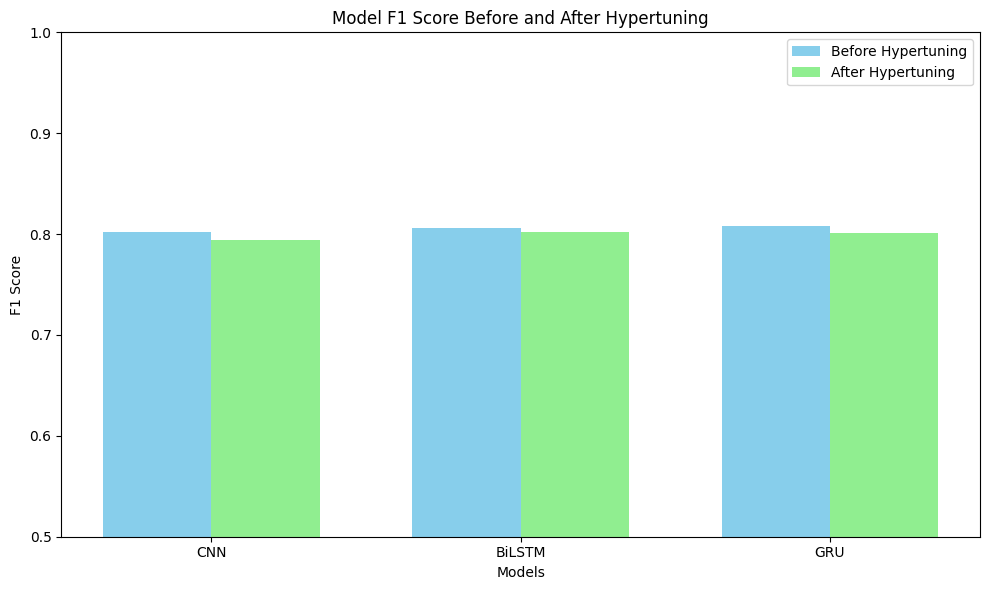

In [100]:
models = ["CNN", "BiLSTM", "GRU"]
# F1 Score before and after hypertuning
f1_before = [f1_cnn, f1_bilstm, f1_gru]
f1_after = [f1_cnn_hypertuned, f1_bilstm_hypertuned, f1_gru_hypertuned]
x = np.arange(len(models))
bar_width = 0.35
plt.figure(figsize=(10, 6))

bars_before = plt.bar(
    x - bar_width / 2, f1_before, bar_width, label="Before Hypertuning", color="skyblue"
)
bars_after = plt.bar(
    x + bar_width / 2,
    f1_after,
    bar_width,
    label="After Hypertuning",
    color="lightgreen",
)

# Add labels, title, and legend
plt.xlabel("Models")
plt.ylabel("F1 Score")
plt.title("Model F1 Score Before and After Hypertuning")
plt.xticks(x, models)
plt.ylim(0.5, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

# The best Classifier

Based on our experimental, we can conclude that **Bi-LSTM model** is perform best compared to other models.